# California Housing Prices Project

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In [2]:
df = pd.read_csv('housing.csv')

In [3]:
df.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

### The median_house_value column is a continuous variable, so we are talking about a regression problem. We are going to follow the following steps:

#### 1. Initial EDA to have a glimpse of the data distribution and the data itself
#### 2. We will deal with the missing data
#### 3. Model test and evaluation
#### 4. Model Selection and improval
#### 5. Conclusion

### 1. Initial EDA

/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


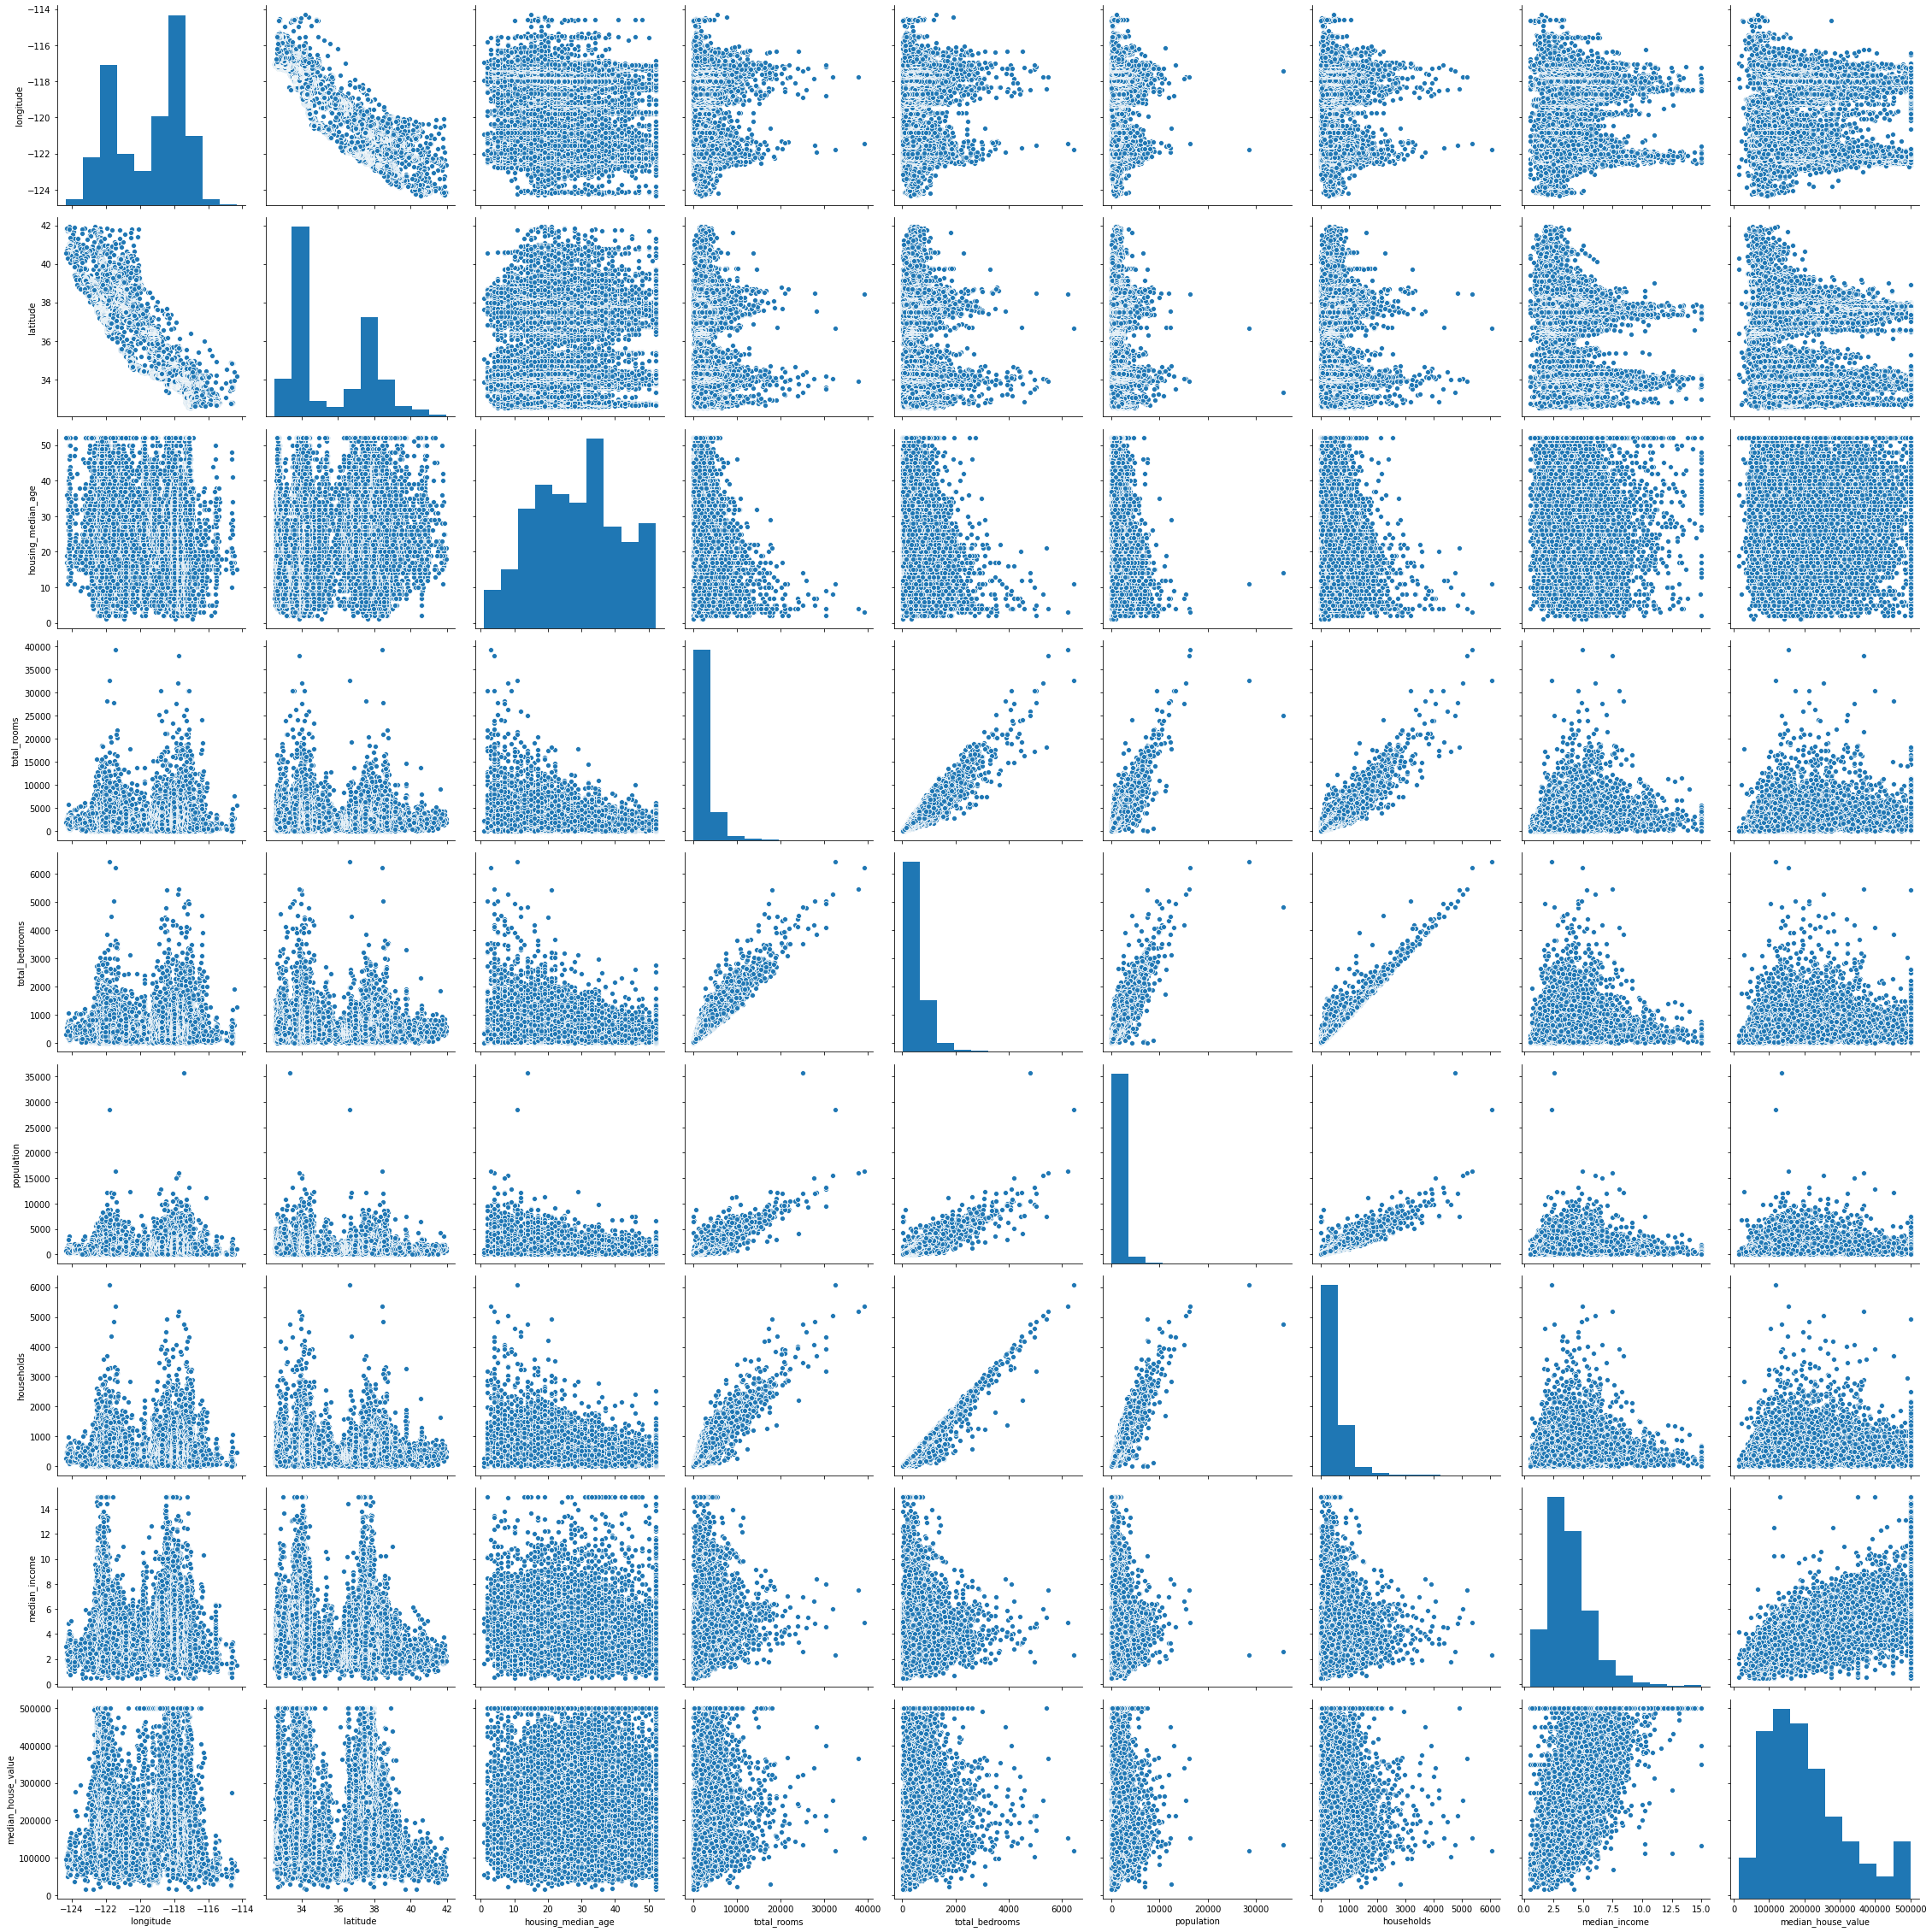

In [6]:
# Let's use a pairplot to have a general idea of the distribution of the data.
sns.pairplot(df, height=3.5)
plt.tight_layout()

In [7]:
# Here we are creating a correlation matrix to understand the relationship among variables.
df.corr().style.background_gradient()

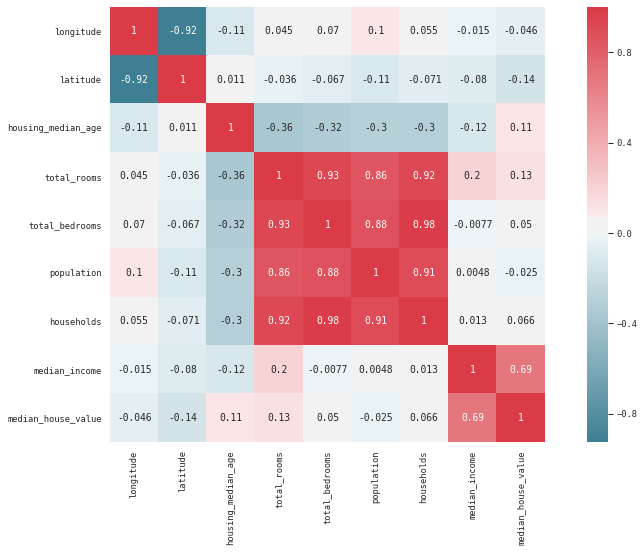

In [8]:
# We can also use a heatmap to see that

sns.set(context="paper",font="monospace")
df_corr_matrix = df.corr()
fig, axe = plt.subplots(figsize=(15,8))
cmap = sns.diverging_palette(220,10,center = "light", as_cmap=True)
sns.heatmap(df_corr_matrix,vmax=1,square =True, cmap=cmap,annot=True);

In [9]:
df['total_rooms'].describe()

count    20640.000000
mean      2635.763081
std       2181.615252
min          2.000000
25%       1447.750000
50%       2127.000000
75%       3148.000000
max      39320.000000
Name: total_rooms, dtype: float64

In [10]:
df['total_bedrooms'].describe()

count    20433.000000
mean       537.870553
std        421.385070
min          1.000000
25%        296.000000
50%        435.000000
75%        647.000000
max       6445.000000
Name: total_bedrooms, dtype: float64

In [11]:
df['median_house_value'].describe()

count     20640.000000
mean     206855.816909
std      115395.615874
min       14999.000000
25%      119600.000000
50%      179700.000000
75%      264725.000000
max      500001.000000
Name: median_house_value, dtype: float64

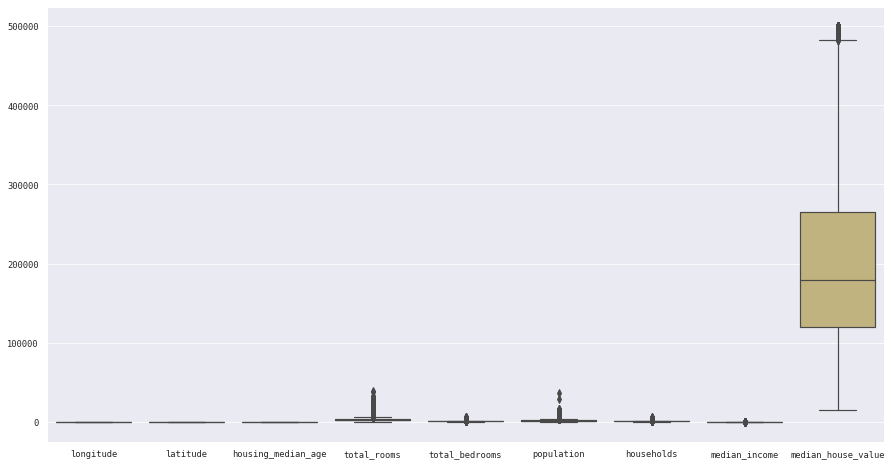

In [12]:
sns.boxplot(data=df)
plt.gcf().set_size_inches(15,8)

In [13]:
# As we saw, there are a ouliers in the column total_rooms. 
# Outliers lie i a distance of 1.5 times the inter quantile range (1.5*IQR)

def getOutliers(dataframe,column):
    column = "total_rooms" 
    #df[column].plot.box(figsize=(8,8))
    des = dataframe[column].describe()
    desPairs = {"count":0,"mean":1,"std":2,"min":3,"25":4,"50":5,"75":6,"max":7}
    Q1 = des[desPairs['25']]
    Q3 = des[desPairs['75']]
    IQR = Q3-Q1
    lowerBound = Q1-1.5*IQR
    upperBound = Q3+1.5*IQR
    print("(IQR = {})\nOutliers are anything outside this range: ({},{})".format(IQR,lowerBound,upperBound))
    #b = df[(df['a'] > 1) & (df['a'] < 5)]
    data = dataframe[(dataframe [column] < lowerBound) | (dataframe [column] > upperBound)]

    print("The total number of outliers from our dataset of {} rows are:\n{}".format(df[column].size,len(data[column])))
    #remove the outliers from the dataframe
    outlierRemoved = df[~df[column].isin(data[column])]
    return outlierRemoved

In [14]:
# Now let's remove the outliers

df_outliersRemoved = getOutliers(df,"total_rooms")

(IQR = 1700.25)
Outliers are anything outside this range: (-1102.625,5698.375)
The total number of outliers from our dataset of 20640 rows are:
1287


### 2. Dealing with missing Data

In [15]:
# Let's see how data is distributed

bedrooms = df.loc[(df['total_bedrooms'].notnull()), 'total_bedrooms']

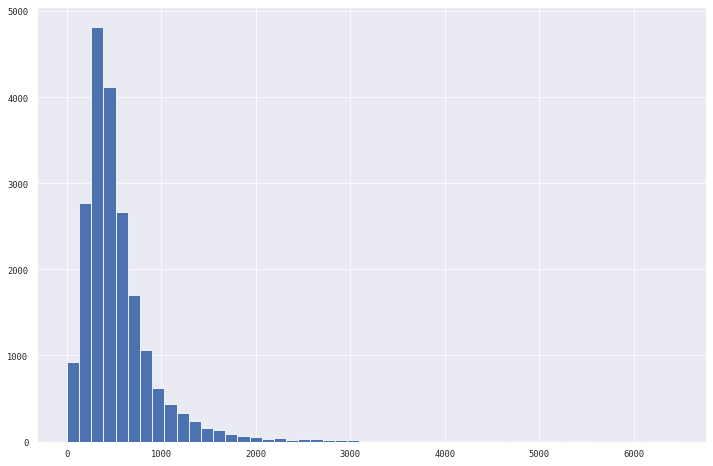

In [16]:
bedrooms.hist(figsize=(12,8),bins=50)

In [17]:
print(df.iloc[:,4:5].head())
imputer = SimpleImputer(np.nan,strategy ="median")
imputer.fit(df.iloc[:,4:5])
df.iloc[:,4:5] = imputer.transform(df.iloc[:,4:5])
df.isnull().sum()

   total_bedrooms
0           129.0
1          1106.0
2           190.0
3           235.0
4           280.0


longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [18]:
# Let's take a look at the variable ocean_proximity, which is categorical

df.ocean_proximity.unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [19]:
# Let's encode it

labelEncoder = LabelEncoder()
df["ocean_proximity"].value_counts()
df["ocean_proximity"] = labelEncoder.fit_transform(df["ocean_proximity"])
df["ocean_proximity"].value_counts()
df.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20640.000000  20640.000000  20640.000000   20640.000000   
mean       536.838857   1425.476744    499.539680       3.870671   
std        419.391878   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        297.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        643.250000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  ocean_proximity  
count        20640.000000     20640.000000  
mean        206855.816909         1.165843  
std         115395.615874         1.420662  
min          14999.000000         0.000000  
25%         119600.000000         0.000000  
50%         179700.000000         1.000000  
75%         264725.000000         1.000000  
max         500001.000000         4.000000

In [20]:
df.ocean_proximity.unique()

array([3, 0, 1, 4, 2])

In [21]:
df.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value  ocean_proximity  
0       322.0       126.0         8.3252            452600.0                3  
1      2401.0      1138.0         8.3014            358500.0                3  
2       496.0       177.0         7.2574            352100.0                3  
3       558.0       219.0         5.6431            341300.0                3  
4       565.0       259.0         3.8462            342200.0                3

### 3. Model test and evaluation

In [22]:
# Here we are going to try Linear regression, Decision tree regression, and random forest regression.
# After we see which one performs best, we can play with the variables and with scaling to see if we can improve the model.

#### 3.1. Linear Regression

In [23]:
X = df.drop("median_house_value",axis=1)
y = df["median_house_value"]

print("Dimensions of y before reshaping: {}".format(y.shape))
print("Dimensions of X before reshaping: {}".format(X.shape))

Dimensions of y before reshaping: (20640,)
Dimensions of X before reshaping: (20640, 9)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [25]:
# Create the regressor: reg_all
reg_all = LinearRegression()

# Fit the regressor to the training data
reg_all.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.6137068886499549
Root Mean Squared Error: 71147.87146118362


In [26]:
# Our R-squared was of 0.6137. This number is basically saying that our current model (using all the independent 
# variables as predictors) can explain about 61.37% of our data.

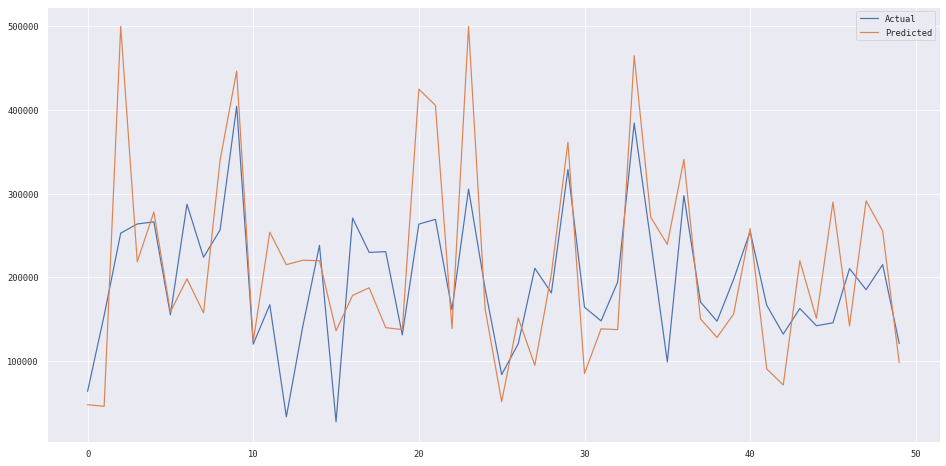

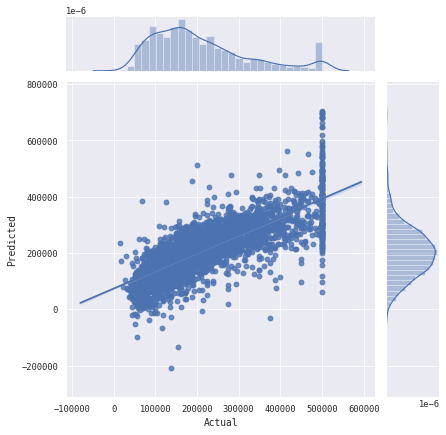

In [27]:
# Here we have some plots on how the predicted model compares to the actual one.

test = pd.DataFrame({'Predicted':y_pred,'Actual':y_test})
fig= plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:50])
plt.legend(['Actual','Predicted'])
sns.jointplot(x='Actual',y='Predicted',data=test,kind='reg',);

#### 3.2. Decision Tree Regression

In [28]:
dtReg = DecisionTreeRegressor(max_depth=9)
dtReg.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [29]:
dtReg_y_pred = dtReg.predict(X_test)
dtReg_y_pred

array([ 60503.2556391 ,  75919.52054795, 478283.56097561, ...,
       488611.25      ,  75919.52054795, 211563.96963563])

In [30]:
# Compute and print R^2 and RMSE
print("R^2: {}".format(dtReg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, dtReg_y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.7168642792126952
Root Mean Squared Error: 60911.705819193136


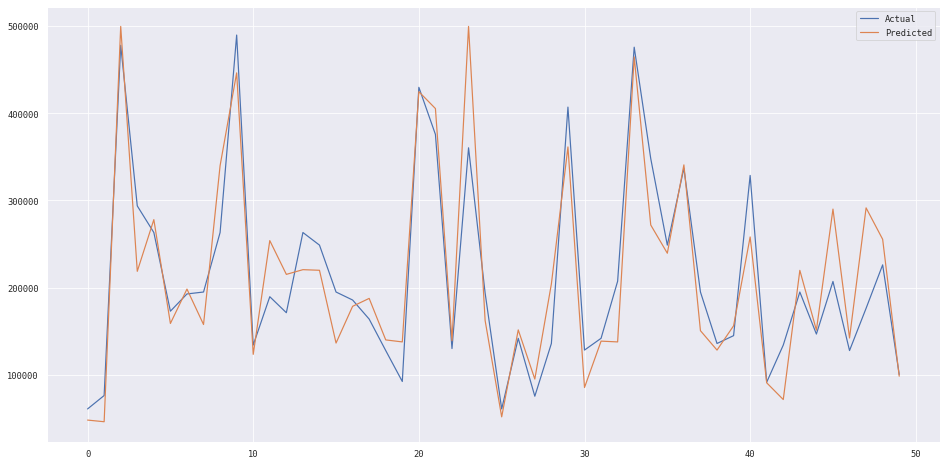

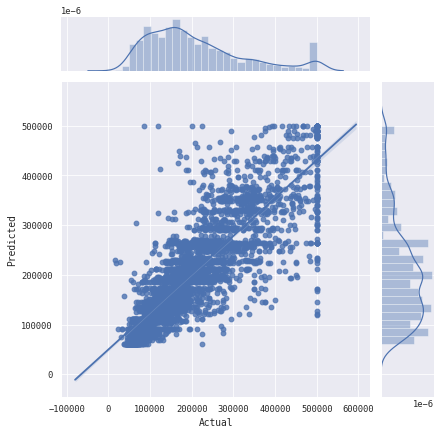

In [31]:
test = pd.DataFrame({'Predicted':dtReg_y_pred,'Actual':y_test})
fig= plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:50])
plt.legend(['Actual','Predicted'])
sns.jointplot(x='Actual',y='Predicted',data=test,kind="reg")

#### 3.3. Random Forest Regression

In [32]:
rfReg = RandomForestRegressor(30)
rfReg.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [33]:
rfReg_y_pred = rfReg.predict(X_test)

In [34]:
# Compute and print R^2 and RMSE
print("R^2: {}".format(rfReg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, rfReg_y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.8053413184155607
Root Mean Squared Error: 50505.6911684996


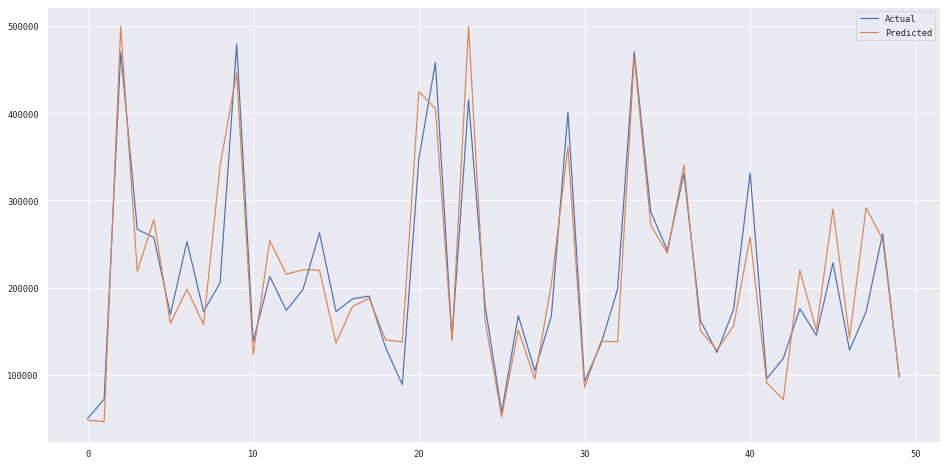

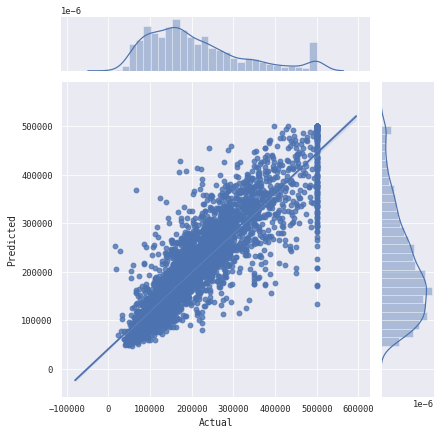

In [35]:
test = pd.DataFrame({'Predicted':rfReg_y_pred,'Actual':y_test})
fig= plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:50])
plt.legend(['Actual','Predicted'])
sns.jointplot(x='Actual',y='Predicted',data=test,kind="reg")

### 4. Model Selection and Improval

#### Considering the tested models, we can conclude that the Random Forest Regression Model can explain more the data than the other models with an R-squared of 0.805. We will now take this model and change some parameters such as variables, scaling, etc.to see if we can improve the model to explain more of the data.

In [36]:
df.corr().style.background_gradient()

In [37]:
# Considering the correlation matrix, the variables that correlate more with median_house_value are:
# housing_median_age, total_rooms, and median_income
# Let's see how the model performs with those variables

In [38]:
data = df[['median_house_value', 'housing_median_age', 'total_rooms', 'median_income']]

In [39]:
data.head()

median_house_value  housing_median_age  total_rooms  median_income
0            452600.0                41.0        880.0         8.3252
1            358500.0                21.0       7099.0         8.3014
2            352100.0                52.0       1467.0         7.2574
3            341300.0                52.0       1274.0         5.6431
4            342200.0                52.0       1627.0         3.8462

In [40]:
X = data.drop("median_house_value",axis=1)
y = data["median_house_value"]

print("Dimensions of y before reshaping: {}".format(y.shape))
print("Dimensions of X before reshaping: {}".format(X.shape))

Dimensions of y before reshaping: (20640,)
Dimensions of X before reshaping: (20640, 3)


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [42]:
rfReg = RandomForestRegressor(30)
rfReg.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [43]:
rfReg_y_pred = rfReg.predict(X_test)

In [44]:
# Compute and print R^2 and RMSE
print("R^2: {}".format(rfReg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, rfReg_y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.4999591240416129
Root Mean Squared Error: 80948.01130005076


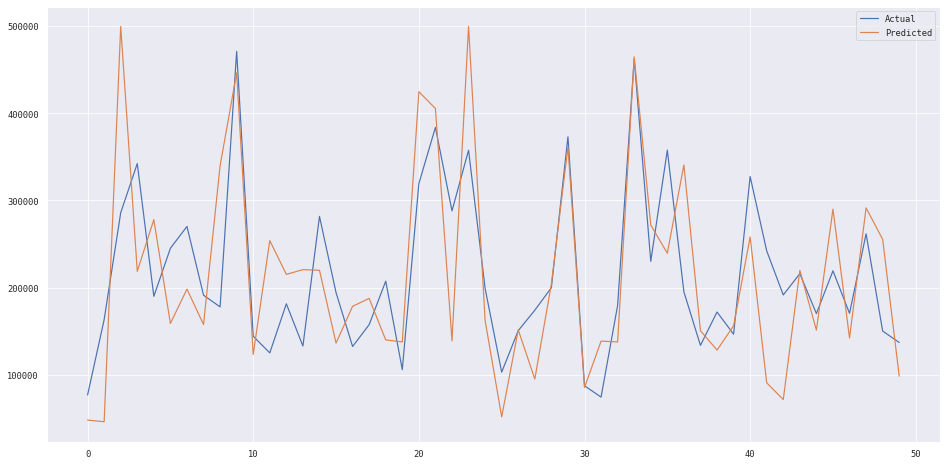

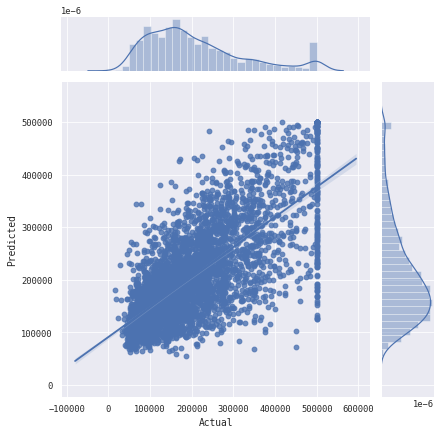

In [45]:
test = pd.DataFrame({'Predicted':rfReg_y_pred,'Actual':y_test})
fig= plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:50])
plt.legend(['Actual','Predicted'])
sns.jointplot(x='Actual',y='Predicted',data=test,kind="reg")

In [46]:
# By limiting the model to 3 variables we actually had a worse performance than before.

In [47]:
# 2 different approaches we can try is to log normalize the total_rooms column and to standardize it, applying the changes
# to the whole dataset to see if the model improves.

In [48]:
df['total_rooms'].var()

4759445.105938626

In [49]:
df['total_rooms_normalized'] = np.log(df['total_rooms'])

In [50]:
df['total_rooms_normalized'].var()

0.5648065729971169

In [51]:
df.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value  ocean_proximity  \
0       322.0       126.0         8.3252            452600.0                3   
1      2401.0      1138.0         8.3014            358500.0                3   
2       496.0       177.0         7.2574            352100.0                3   
3       558.0       219.0         5.6431            341300.0                3   
4       565.0       259.0         3.8462            342200.0                3   

   total_rooms_normalized  
0                6.779922  
1                8.867709  
2                7.290975  
3                7.149917  
4                7.394493

In [52]:
df2 = df.drop('total_rooms', axis=1)

In [53]:
df2.head()

longitude  latitude  housing_median_age  total_bedrooms  population  \
0    -122.23     37.88                41.0           129.0       322.0   
1    -122.22     37.86                21.0          1106.0      2401.0   
2    -122.24     37.85                52.0           190.0       496.0   
3    -122.25     37.85                52.0           235.0       558.0   
4    -122.25     37.85                52.0           280.0       565.0   

   households  median_income  median_house_value  ocean_proximity  \
0       126.0         8.3252            452600.0                3   
1      1138.0         8.3014            358500.0                3   
2       177.0         7.2574            352100.0                3   
3       219.0         5.6431            341300.0                3   
4       259.0         3.8462            342200.0                3   

   total_rooms_normalized  
0                6.779922  
1                8.867709  
2                7.290975  
3                7.149917  
4                7.394493

In [54]:
# Now let's see the result of normalizing the column total_rooms

In [55]:
X = df2.drop("median_house_value",axis=1)
y = df2["median_house_value"]

print("Dimensions of y before reshaping: {}".format(y.shape))
print("Dimensions of X before reshaping: {}".format(X.shape))

Dimensions of y before reshaping: (20640,)
Dimensions of X before reshaping: (20640, 9)


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [57]:
rfReg = RandomForestRegressor(30)
rfReg.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [58]:
rfReg_y_pred = rfReg.predict(X_test)

In [59]:
# Compute and print R^2 and RMSE
print("R^2: {}".format(rfReg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, rfReg_y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.8098369780323973
Root Mean Squared Error: 49919.06763109343


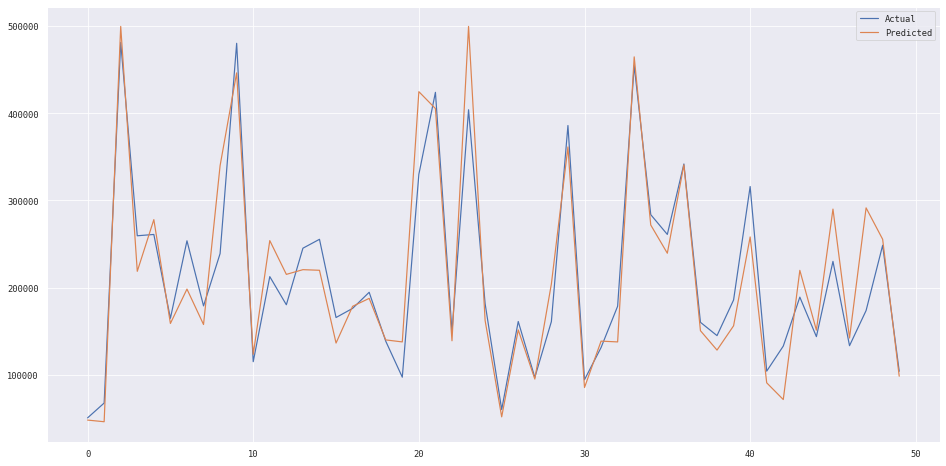

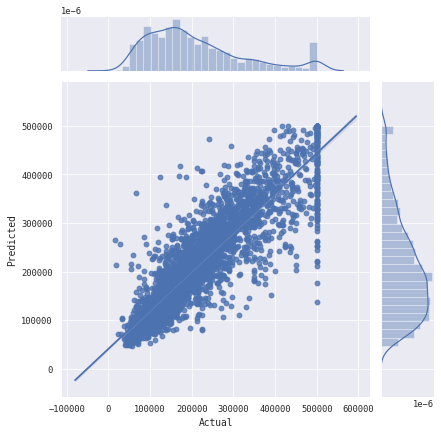

In [60]:
test = pd.DataFrame({'Predicted':rfReg_y_pred,'Actual':y_test})
fig= plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:50])
plt.legend(['Actual','Predicted'])
sns.jointplot(x='Actual',y='Predicted',data=test,kind="reg")

In [61]:
# We slightly improved the model by having a higher R-squared of 0.809 and a smaller root mean squared error.

In [62]:
# Now let's try to standardize the dataset by using the StandardScaler

In [63]:
df3 = df.drop('total_rooms_normalized', axis=1)

In [64]:
df3.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value  ocean_proximity  
0       322.0       126.0         8.3252            452600.0                3  
1      2401.0      1138.0         8.3014            358500.0                3  
2       496.0       177.0         7.2574            352100.0                3  
3       558.0       219.0         5.6431            341300.0                3  
4       565.0       259.0         3.8462            342200.0                3

In [65]:
ss = StandardScaler()

In [74]:
df3_scaled = ss.fit_transform(df3[['housing_median_age', 'total_rooms', 'total_bedrooms', 'median_income']])

In [75]:
X_train, X_test, y_train, y_test = train_test_split(df3_scaled, y, test_size=0.2, random_state=42)

In [76]:
rfReg = RandomForestRegressor(30)
rfReg.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [77]:
rfReg_y_pred = rfReg.predict(X_test)

In [78]:
# Compute and print R^2 and RMSE
print("R^2: {}".format(rfReg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, rfReg_y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.5620128481998216
Root Mean Squared Error: 75758.97940660987


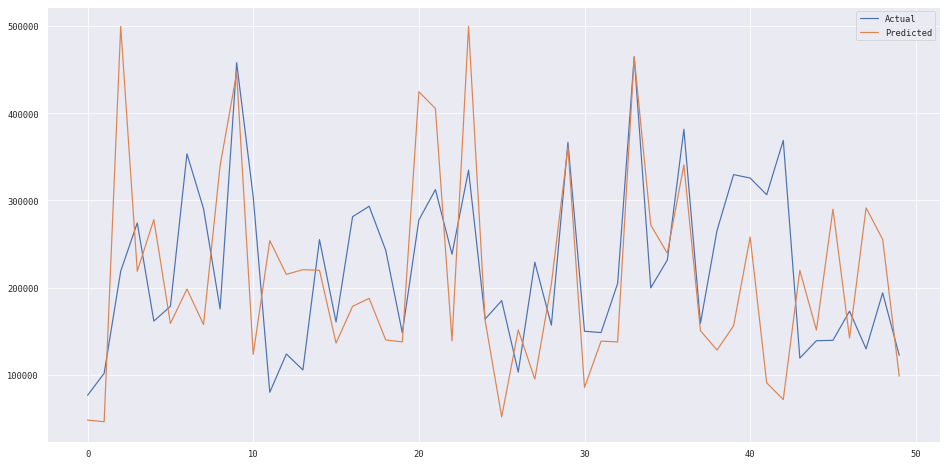

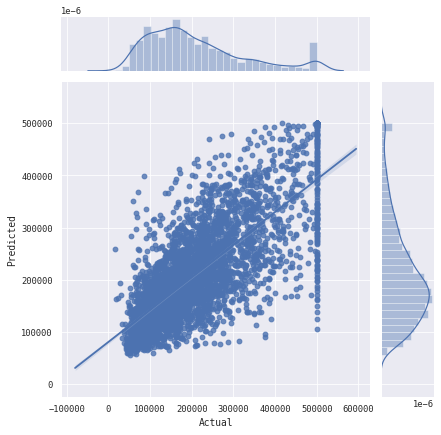

In [79]:
test = pd.DataFrame({'Predicted':rfReg_y_pred,'Actual':y_test})
fig= plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:50])
plt.legend(['Actual','Predicted'])
sns.jointplot(x='Actual',y='Predicted',data=test,kind="reg")

In [80]:
# By subseting the dataset and scaling it, we got a worse result. 

In [81]:
# Another thing we can try is to see if we have other columns with a high variance and normalize them.

In [82]:
df.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20640.000000  20640.000000  20640.000000   20640.000000   
mean       536.838857   1425.476744    499.539680       3.870671   
std        419.391878   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        297.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        643.250000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  ocean_proximity  total_rooms_normalized  
count        20640.000000     20640.000000            20640.000000  
mean        206855.816909         1.165843                7.628577  
std         115395.615874         1.420662                0.751536  
min          14999.000000         0.000000                0.693147  
25%         119600.000000         0.000000                7.277766  
50%         179700.000000         1.000000                7.662468  
75%         264725.000000         1.000000                8.054523  
max         500001.000000         4.000000               10.579489

In [83]:
df['population'].var()

1282470.4572332504

In [84]:
df['total_bedrooms'].var()

175889.54726668005

In [85]:
df4 = df.drop('total_rooms', axis=1)

In [86]:
df4.head()

longitude  latitude  housing_median_age  total_bedrooms  population  \
0    -122.23     37.88                41.0           129.0       322.0   
1    -122.22     37.86                21.0          1106.0      2401.0   
2    -122.24     37.85                52.0           190.0       496.0   
3    -122.25     37.85                52.0           235.0       558.0   
4    -122.25     37.85                52.0           280.0       565.0   

   households  median_income  median_house_value  ocean_proximity  \
0       126.0         8.3252            452600.0                3   
1      1138.0         8.3014            358500.0                3   
2       177.0         7.2574            352100.0                3   
3       219.0         5.6431            341300.0                3   
4       259.0         3.8462            342200.0                3   

   total_rooms_normalized  
0                6.779922  
1                8.867709  
2                7.290975  
3                7.149917  
4                7.394493

In [87]:
df4['population_normalized'] = np.log(df4['population'])

In [88]:
df4['population_normalized'].var()

0.5454180135051833

In [89]:
df4['total_bedrooms_normalized'] = np.log(df4['total_bedrooms'])

In [90]:
df4['total_bedrooms_normalized'].var()

0.5315948044326639

In [91]:
df4.drop(columns=['total_bedrooms', 'population'], axis=1, inplace=True)

In [92]:
df4.head()

longitude  latitude  housing_median_age  households  median_income  \
0    -122.23     37.88                41.0       126.0         8.3252   
1    -122.22     37.86                21.0      1138.0         8.3014   
2    -122.24     37.85                52.0       177.0         7.2574   
3    -122.25     37.85                52.0       219.0         5.6431   
4    -122.25     37.85                52.0       259.0         3.8462   

   median_house_value  ocean_proximity  total_rooms_normalized  \
0            452600.0                3                6.779922   
1            358500.0                3                8.867709   
2            352100.0                3                7.290975   
3            341300.0                3                7.149917   
4            342200.0                3                7.394493   

   population_normalized  total_bedrooms_normalized  
0               5.774552                   4.859812  
1               7.783641                   7.008505  
2               6.206576                   5.247024  
3               6.324359                   5.459586  
4               6.336826                   5.634790

In [93]:
X = df4.drop("median_house_value",axis=1)
y = df4["median_house_value"]

print("Dimensions of y before reshaping: {}".format(y.shape))
print("Dimensions of X before reshaping: {}".format(X.shape))

Dimensions of y before reshaping: (20640,)
Dimensions of X before reshaping: (20640, 9)


In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [95]:
rfReg = RandomForestRegressor(30)
rfReg.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [96]:
rfReg_y_pred = rfReg.predict(X_test)

In [97]:
# Compute and print R^2 and RMSE
print("R^2: {}".format(rfReg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, rfReg_y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.8022939264744212
Root Mean Squared Error: 50899.49054761491


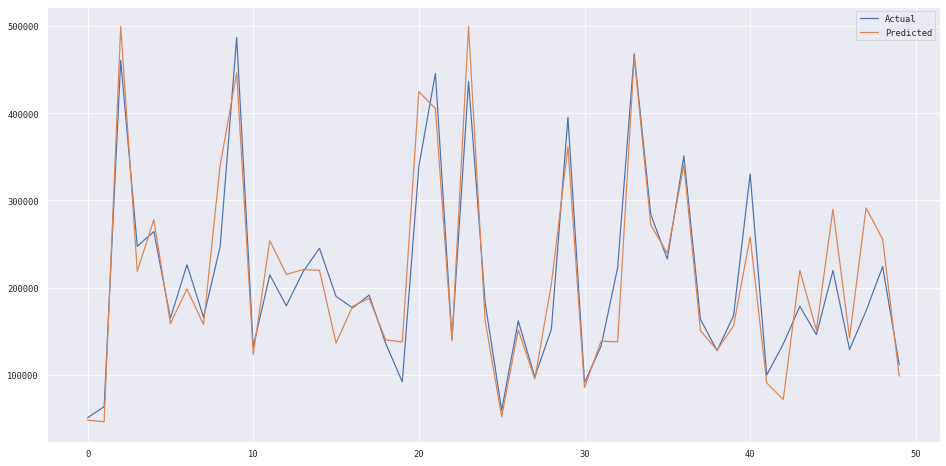

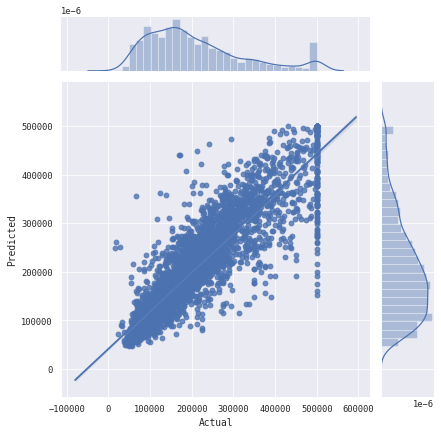

In [98]:
test = pd.DataFrame({'Predicted':rfReg_y_pred,'Actual':y_test})
fig= plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:50])
plt.legend(['Actual','Predicted'])
sns.jointplot(x='Actual',y='Predicted',data=test,kind="reg")

### 5. Conclusion

In [99]:
# What we conclude is that the best model is the Random Forest Regression. 
# The model improves a little more when we normalize the total_rooms column, which has the highest variance amongst all
# columns. 
# the model has:

# R-squared - 0.8098
# Root mean squared error - 49919.067

# Which means that our model can predict about 81% of the data we have